This script takes land use data for the municipality of Belo Horizonte and regroups the original categories into simpler, more aggregate categories. The level of disaggregation present in the original data not only is unnecessary, for the purposes of the Thesis, but it would add up to a higher level of complications and noise, not the mention the more elevated computational costs.

Then, land use geometries are parsed into a grid of Uber's H3 Hexagons of resolution that is akin to the area of the median parcel in belo Horizonte municipality. These hexagons also contain populational counts and income as per the 2010 Census.

The script has at first been written with the 2017 land use map, which was readily available online. Afterwards, the years 2011, 2018, and 2020 maps are parsed into hexagons using the same functions but with some minor tunings.

# Land Use Maps for 2017

data source: http://bhmap.pbh.gov.br

In [1]:
import os
import pathlib

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from h3census.assemble import get_hexagons_with_census_data
from shapely.geometry import mapping, Point, Polygon

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Preliminaries

### Parent Folders

These should of course be adjusted to reflect the appropriate locations in your disk or wherever

In [2]:
out_folder = os.environ.get('OUT_FOLDER')
out_folder = pathlib.Path(out_folder)
out_folder = out_folder / 'A'

db_folder = os.environ.get('DB_FOLDER')
db_folder = pathlib.Path(db_folder)

### General Purpose

In [3]:
def _get_zipped_path_for_gpd(path):
    """This gets a full path for a zipped shp file and parses it
    into a structure that gpd.read_file() understands.
    """
    prefix = r'zip://'
    
    try:
        path = prefix + path.as_posix()
    except:
        path = pathlib.PureWindowsPath(path)
        path = prefix + path.as_posix()
        
    return path

## Getting Data

In [4]:
def get_land_uses(path, is_zipped=True):
    """Takes either a full raw string path os a pathlib's pure windows
    path and uses it to return a shapefile. It also makes the necessary
    adjustments to read shapefiles compressed into a .zip file.
    """    
    if is_zipped:
        path = _get_zipped_path_for_gpd(path)
            
    return gpd.read_file(path)

## Initial Exploration and Preliminary Wrangling

In [5]:
path = db_folder / 'Belo Horizonte e Região/TIPOLOGIA_USO_OCUPACAO/USO_OCUP_2017.zip'

land_uses = get_land_uses(path)

# some later operations don't handle well a mix of Polygons and MultyPolygons
land_uses = land_uses.explode()
land_uses.reset_index(drop=True, inplace=True)

In [6]:
land_uses.head(2)

ID_TP_USO_      NULOTCTM   TIPOLOGIA_        TIPOLOGIA0  \
0    304274.0  091029400040  RESIDENCIAL  casa unifamiliar   
1    304275.0  091029400030        MISTO      casa/sobrado   

                                            geometry  
0  POLYGON ((607797.123 7793915.752, 607787.343 7...  
1  POLYGON ((607808.568 7793920.691, 607797.444 7...

In [7]:
print(land_uses.crs)

epsg:31983


In [8]:
new_names = {'TIPOLOGIA_': 'type', 'TIPOLOGIA0': 'category'}
land_uses.rename(columns=new_names, inplace=True)

to_keep = ['type', 'category', 'geometry']
land_uses = land_uses.reindex(columns=to_keep)

del new_names, to_keep

In [9]:
number_of_parcels = len(land_uses)
land_uses['type'].value_counts() / number_of_parcels * 100

RESIDENCIAL                  60.464682
MISTO                         7.835141
LOTE VAGO                     7.821213
NAO RESIDENCIAL               7.199762
RESIDENCIAL+LOTE VAGO         0.466019
NAO RESIDENCIAL+LOTE VAGO     0.224792
MISTO + LOTE VAGO             0.100279
Name: type, dtype: float64

In [10]:
land_uses.category.value_counts() / number_of_parcels * 100

casa unifamiliar                                 54.869108
sem informacao                                   15.712622
casa/sobrado                                      6.197528
lote vago                                         4.514231
edificio                                          4.461028
loja ou conjunto de lojas                         4.080803
galpao                                            3.369100
edificação sem tipologia especificada             3.149600
conjunto multifamiliar vertical                   1.426749
edificio residencial e comercio e/ou servicos     0.711703
edificio de uso comercial e/ou servicos           0.468805
parque                                            0.345684
instituicao de ensino                             0.147355
loja em edificio/galeria                          0.111143
conjunto multifamiliar horizontal                 0.104736
ocupação diversificada                            0.084402
industria                                         0.0523

The regrouping of land uses aims at reducing the number of categories by bringing together like things that are apart for some reason. The rationale below refers to the 2017 land use map and it might (and probably will) be slightly different for the other years.

Most instances a plain obvious, e.g. 'casa unifamiliar', which is clearly residential. Those are grouped under 'clear_regrouping_2017'.

A minor number of instances require some ad hoc decisions and assumptions, which were ostly taken by comparing 'type' and 'category' attributes. Specifically:
- There were cases in which discordant classifications were residual. Hence, the residuals have been put together along with the majority class. For example, there are 6 mixed use parcels of 'edificio' amidst a sea of 16009 residential parcels.
- There are two categories that are unclear in of themselves ('ocupação diversificada', 'vaga residencial ou comercial') these have been classified with the aid of 'type' column — see _reclassify_ad_hoc() function.
- 'sem informacao' was assumed to be vacant
- 'galpao' at first seemed obviously related to the industrial sector, but a closer look at its spatial distribution, along with a couple checks in Google maps, made it seem otherwise. It did not seem, for the most part, related to heavy industry, specially the parcels of this category that were placed within the city's core and along its major roads. Hence, for the time being, it was placed under either retail/services or mixed, until some later analysis reveals otherwise, if such a thing is revealed at all. The choice between mixed and retail/services is made within _reclassify_ad_hoc().
- Mixed uses present a challenge because the classical model deals with discrete classifications only. There are models that allow for some fuzzy classification, which means that a cell can go from fully residential to completely commercial, while being able to assume any percentual balance in between those extremes. Unfortunatelly, to the best of my knowledge, such models seem still incipient and displaying some perks that I don't think are for me to solve (at least not now). Hence, I chose to create a 'mixed' category and leave it at that. After some future experimentations, I might choose to place it either under retail/services or under residential.

In [11]:
clear_regrouping_2017 = {
    'active': {
        'residential': ['casa unifamiliar',
                        'edificio', 
                        'conjunto multifamiliar vertical',
                        'conjunto multifamiliar horizontal',
                        ],
        'retail/services': ['loja ou conjunto de lojas',
                            'edificio de uso comercial e/ou servicos',
                            'loja em edificio/galeria',
                            'shopping center',
                            'galeria/mini shopping de bairro',
                            'apart hotel',
                           ],
        # TO DO: settle approach towards mixed uses
        'mixed': ['casa/sobrado',
                  'edificio residencial e comercio e/ou servicos',]
                },

     'passive': {
         'vacant': ['edificação sem tipologia especificada',
                  'lote vago',
                  'sem informacao',]
                 },

     'static': {'industry': ['industria',
                            ],
                'public_facility': ['instituicao de ensino',
                                    'equipamento de saude',
                                    'instituicao religiosa',
                                    'cemiterio',
                                    ],
                'public_amenity': ['parque',
                                   'clubes esportivos e sociais',
                                   'estadio/ginasio',
                                  ],                     
                'public_infrastructure': ['aterro sanitario',
                                          'estacao de transporte coletivo',
                                          'aeroporto',]
               }
                        }
# These depend on an ad hoc analysis 
unclear_categories = ['ocupação diversificada',
                      'vaga residencial ou comercial',
                      'galpao',] # TO DO: assert the placing of this category here

In [12]:
def _reclassify_ad_hoc(gdf):
    """Deals with some perks that seem too specific for generalization.
    Handles instances in which TIPOLOGIA0 may be more accurately placed
    when analyzed together with TIPOLOGIA_
    """
    # ocupação diversificada
    # ----------------------
    mask_a = gdf.category=='ocupação diversificada'
    mask_b = gdf['type'].isin(['RESIDENCIAL', 'RESIDENCIAL+LOTE VAGO'])
    mask_c = gdf['type'].isin(['MISTO', 'MISTO + LOTE VAGO'])
    
    full_mask = mask_a & mask_b
    gdf.loc[full_mask,'category'] = 'residential'
    
    full_mask = mask_a & mask_c
    gdf.loc[full_mask,'category'] = 'mixed'
    
    full_mask = mask_a & (~mask_b) & (~mask_c)
    gdf.loc[full_mask,'category'] = 'retail/services'
    
    # vaga residencial ou comercial
    # -----------------------------
    mask_d = gdf.category=='vaga residencial ou comercial'
    mask_e = gdf['type']=='NAO RESIDENCIAL'
    mask_f = gdf['type']=='RESIDENCIAL'
    
    full_mask = mask_d & mask_e
    gdf.loc[full_mask,'category'] = 'retail/services'
    
    full_mask = mask_d & mask_f
    gdf.loc[full_mask,'category'] = 'residential'
    
    full_mask = mask_d & (~mask_e) & (~mask_f)
    gdf.loc[full_mask,'category'] = 'mixed'
    
    # galpao
    # ------
    mask_g = gdf.category=='galpao'
    
    full_mask = mask_g & mask_c
    gdf.loc[full_mask,'category'] = 'mixed'
    
    full_mask = mask_g & (~mask_c)
    gdf.loc[full_mask,'category'] = 'retail/services'
    
    # Final adjustment
    # ----------------
    cat_list = ['residential', 'retail/services', 'mixed', 'galpao'] 
    gdf.loc[gdf.category.isin(cat_list), 'type'] = 'active'
    

def reclassify_land_uses(gdf, dictionary):
    _reclassify_ad_hoc(gdf)
    for key in dictionary.keys():
        for umbrella_category,old_categories in dictionary[key].items():
            mask = gdf.category.isin(old_categories)
            gdf.loc[mask, 'type'] = key
            
            replacement_dict = {
                cat: umbrella_category
                for cat
                in old_categories
                                }
            view = gdf.loc[mask,'category']
            gdf.update(view.replace(replacement_dict))

In [13]:
reclassify_land_uses(land_uses, clear_regrouping_2017)

In [14]:
number_of_parcels = len(land_uses)
land_uses['type'].value_counts() / number_of_parcels * 100

active     75.968111
passive    23.376453
static      0.655435
Name: type, dtype: float64

In [15]:
land_uses.category.value_counts() / number_of_parcels * 100

residential              60.912596
vacant                   23.376453
mixed                     7.880545
retail/services           7.174970
public_amenity            0.369361
public_facility           0.229528
industry                  0.052368
public_infrastructure     0.004178
Name: category, dtype: float64

In [16]:
def get_hexagon_edge(land_uses):
    """Computes the edge of an hexagon with the same area as that
    of the median parcel. Requires projected CRS.
    """
    land_parcel_areas = land_uses.geometry.map(lambda x: x.area)
    median_area = np.median(land_parcel_areas)
    
    
    return np.sqrt(median_area*2/(3*np.sqrt(3)))


mask = land_uses['type'] != 'static'
hex_edge = get_hexagon_edge(land_uses.loc[mask])
print(f'Hex edge should be of approximately {hex_edge:.2f} meters')

Hex edge should be of approximately 11.80 meters


That leaves either H3 resolution 11 (edge length of approx. 25m) or resolution 12 (~9.5m) — _refer to https://h3geo.org/docs/core-library/restable/ for H3 resolutions_

_**Resolution 11**_ seems close enough and it's most certainly better for processing purposes. This resolution will be the basis for all subsequent analysis in the other scripts.



## Retrieving Hexagons

Those are to be the main spatial unit of analysis throughout the Thesis

In [17]:
state = 31 # MG ID as int
ibgeID = '3106200' # Belo Horizonte ID as str
                   # TO DO: allow ibgeID as int as well
hexagon_size = 11

census_folder = db_folder / 'Census/2010 Universo/'
path_to_census = census_folder / '2010_aggregates_by_enumeration_area.csv'

usecols = {
    'v002': 'pop',
    # Average income of all those who are 10 years
    # or older and earn wages of some sort
    'v011': 'income',
         }

# TO DO: allow for 'area_weighted_vars' and
# 'pop_weighted_vars' not to be lists
hexagons = get_hexagons_with_census_data(state,
                                         ibgeID,
                                         hexagon_size,
                                         usecols,
                                         area_weighted_vars=['pop'],
                                         query_data=False,
                                         save_query=False,
                                         path=path_to_census,
                                         pop_col='pop',
                                         pop_weighted_vars=['income'],
                                         output_epsg=31983,)

Sanity check:
 141424 H3 labels, with resolution 11,  after dropping 0 duplicates


In [18]:
def input_uses_into_hex(land_uses, hexagons):
    """This goes hexagon by hexagon, checks what land
    uses are contained within and attributes it to the entire
    hexagon the land use that ocupies most of its area.
    
    TO DO: this smells of inneficiency. Think of another way later
    """
    # I used reset index method in hexagons as a way to
    # retain hexagon labels after overlay
    overlay = gpd.overlay(land_uses,
                          hexagons.reset_index(),
                          how='intersection',)
    hex_land_uses = {}
    for hex_label,group in overlay.groupby(f'{hexagons.index.name}'):
        gdf = group.dissolve(by='category', aggfunc='first')
        gdf['area'] = gdf.geometry.map(lambda x: x.area)
        # Mind that gdf is indexed by 'category' because of dissolve
        idxmax = gdf.area.idxmax()
        hex_land_uses[hex_label] = {'type': gdf.loc[idxmax, 'type'],
                                    'category': idxmax,}
    
    
    return pd.DataFrame.from_dict(hex_land_uses, orient='index')
    
    
hex_land_uses = input_uses_into_hex(land_uses, hexagons)

In [19]:
hex_ = hexagons.merge(hex_land_uses,
                      how='inner',
                      left_index=True,
                      right_index=True,)

In [20]:
path_to_hexes = out_folder / f'BH_hex_{hexagon_size}_with_land_uses.gpkg'

hex_.to_file(path_to_hexes, layer='2017', driver='GPKG')

(596923.480970482, 620747.2258779599, 7780043.409061071, 7814479.196207651)

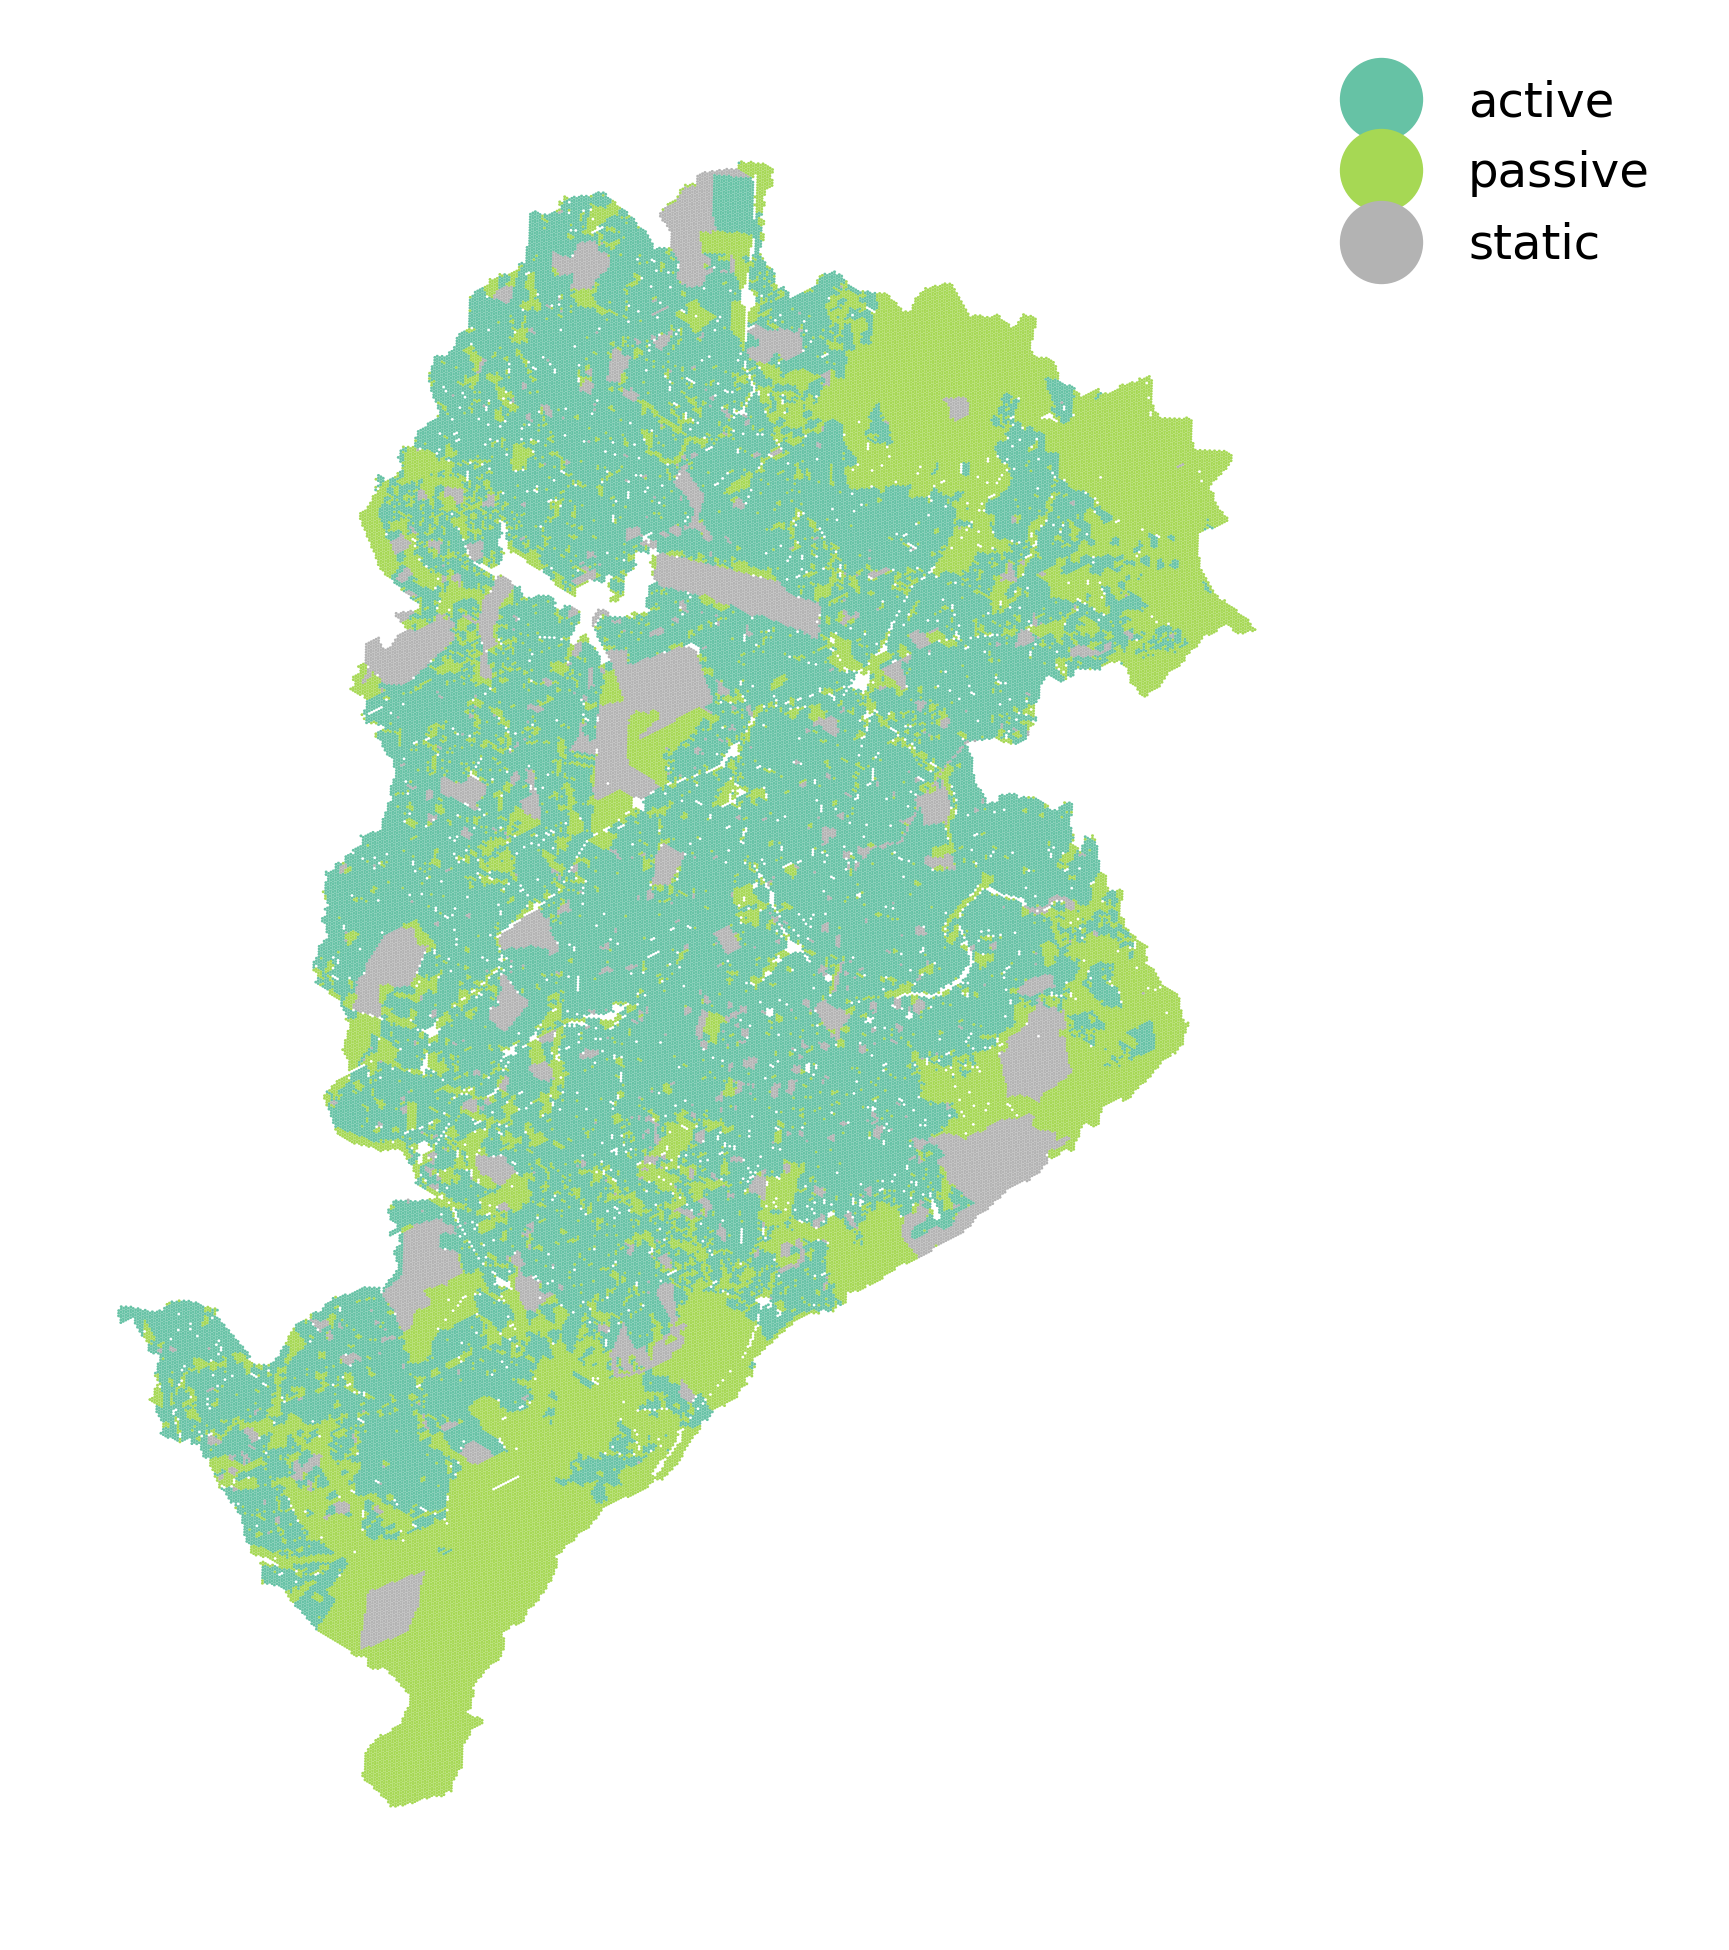

In [21]:
legend_kwds = {
    'loc': 'upper left',
    'bbox_to_anchor': (1,1.01),
    'ncol': 1,
    'borderaxespad': 0,
    'frameon':False,
    'fontsize': 'xx-small',
}

fig,ax = plt.subplots(dpi=300)
hex_.plot(ax=ax,
          column='type',
          cmap='Set2',
          legend=True,
          legend_kwds=legend_kwds,)
ax.axis('off')

(596923.480970482, 620747.2258779599, 7780043.409061071, 7814479.196207651)

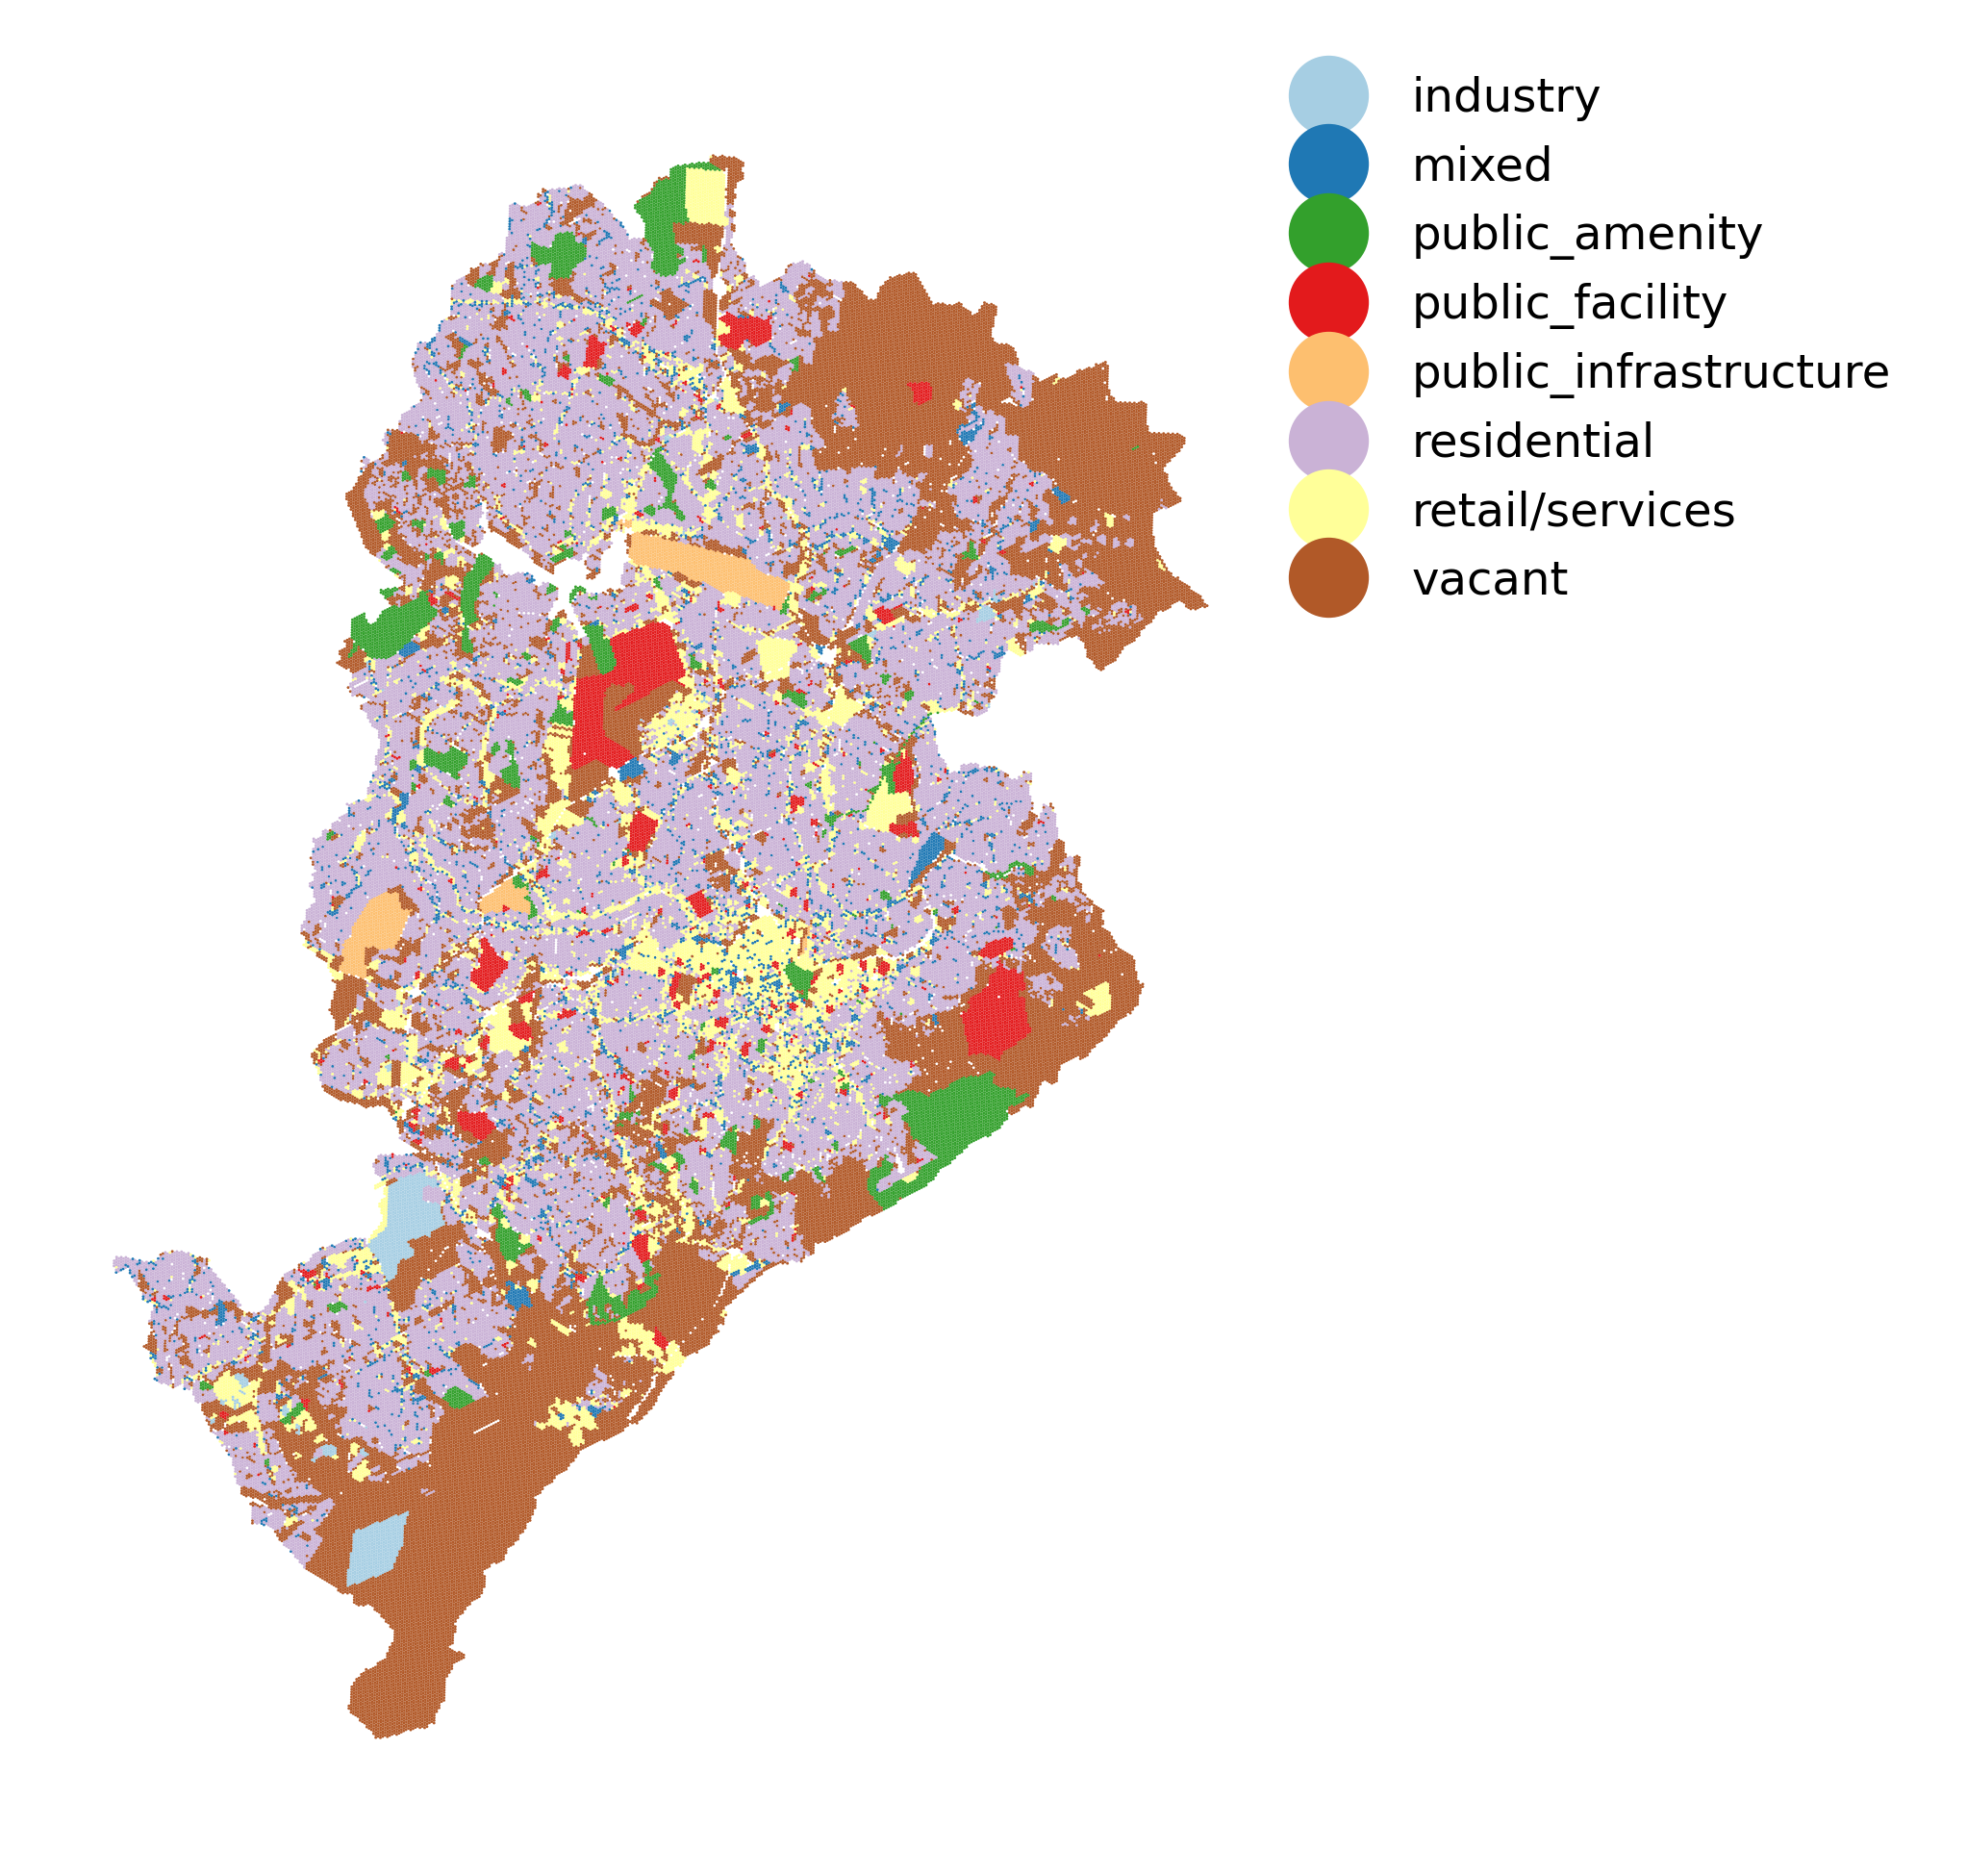

In [22]:
fig,ax = plt.subplots(dpi=300)
hex_.plot(ax=ax,
          column='category',
          cmap='Paired',
          legend=True,
          legend_kwds=legend_kwds,)
ax.axis('off')